In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torchsummary import summary
from torch import optim

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import os

# display images
from torchvision import utils
# import matplotlib.pyplot as plt
# %matplotlib inline

# utils
import numpy as np
# from torchsummary import summary
import time
import copy

import torchOptics.optics as tt
import warnings
warnings.filterwarnings('ignore') ## ignore warnings
meta = {'wl' : (638e-9), 'dx':(6.3e-6, 6.3e-6)}

In [15]:
!nvidia-smi

Sun Mar 24 16:27:10 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:67:00.0 Off |                  N/A |
|  0%   24C    P2   125W / 350W |   2477MiB / 24576MiB |     11%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
gc.collect()
torch.cuda.empty_cache()

In [6]:
import torch.nn.functional as F
import torchvision
import glob
class Dataset512(Dataset):
    # binary hologram and simulation dataset
    # x : simulation
    # y : binary hologram
    def __init__(self, target_dir, meta, transform = None):
        self.target_dir = target_dir
        self.transform = transform
        self.meta = meta
        self.target_list = sorted(glob.glob(target_dir+'*.png'))
        self.resize = torchvision.transforms.CenterCrop(512)

    def __len__(self):
        return len(self.target_list)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        target = tt.imread(self.target_list[idx], meta=meta, gray = True)
        # print(target.shape)
        target = target.unsqueeze(0)
        target = self.resize(target)
        # sim = tt.imread(self.sim_list[idx],meta = meta, gray = True)
        # sample = {'target' : target}
        return target
batch_size = 1
target_dir = 'dataset/DIV2K/DIV2K_train_HR/'
valid_dir = 'dataset/DIV2K/DIV2K_valid_HR/'
# sim_dir = 'binary_dataset/simulated/'

# target_dir = '512dataset/artwork/'
# valid_dir = '512dataset/dishes/'

meta = {'wl' : (638e-9), 'dx':(6.3e-6, 6.3e-6)}
train_dataset = Dataset512(target_dir = target_dir, meta = meta)
valid_dataset = Dataset512(target_dir = valid_dir, meta = meta)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [7]:
len(train_dataset)

800

In [8]:
len(valid_dataset)

100

In [9]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc

class SignFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        output = (torch.sign(input)+1)/2
        output = output.type(torch.int32)
        output = output.type(torch.float32)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output * torch.ones_like(input)  # Replace with your custom gradient computation
        return grad_input
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(BasicBlock, self).__init__()
        # self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(x))
        # out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        return torch.cat([x, out], 1)

class TransitionDownBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(TransitionDownBlock, self).__init__()
        # self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.droprate = dropRate
        self.pooling = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=2, padding=1)
    def forward(self, x):
        out = self.conv1(self.relu(x))
        # out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        return self.pooling(out)

class TransitionUpBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(TransitionUpBlock, self).__init__()
        inter_planes = out_planes*4
        self.conv1 = nn.Conv2d(in_planes, inter_planes, kernel_size=3, stride=1, 
                               padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.unpool = nn.ConvTranspose2d(inter_planes, inter_planes, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.conv2 = nn.Conv2d(inter_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
    def forward(self, x):
        out = self.relu(self.conv1(x))
        # out = self.unpool(out, output_size=out.size())
        out = self.unpool(out)
        out = self.relu(self.conv2(out))
        return out
        
class DenseBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, growth_rate, block, dropRate=0.0):
        super(DenseBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, growth_rate, nb_layers, dropRate)
    def _make_layer(self, block, in_planes, growth_rate, nb_layers, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(in_planes+i*growth_rate, growth_rate, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

class DenseNet3(nn.Module):
    def __init__(self, depth, growth_rate=16,
                 reduction=0.5, bottleneck=True, dropRate=0.0, num_hologram=1):
        super(DenseNet3, self).__init__()
        in_planes = 2 * growth_rate
        block = BasicBlock
        n = depth
        channel_list = []
        # 1st conv before any dense block
        self.conv1 = nn.Conv2d(1, in_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)  # 1 > 2*growth_rate = 32 # 2048>1024
        self.pool1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=2, padding=1)
        # 1 for grayscale
        # 1st block
        self.block1 = DenseBlock(n, in_planes, growth_rate, block, dropRate) 
        in_planes = int(in_planes+n*growth_rate)  # 32 > 32+3*16 = 80
        channel_list.append(in_planes)
        self.trans1 = TransitionDownBlock(in_planes, int(math.floor(in_planes*reduction)), 
                                          dropRate=dropRate)  # 1024>512
        in_planes = int(math.floor(in_planes*reduction))  # 80 > 80*0.5 = 40
        # 2nd block
        self.block2 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)  # 40 > 88
        channel_list.append(in_planes)
        self.trans2 = TransitionDownBlock(in_planes, int(math.floor(in_planes*reduction)), 
                                          dropRate=dropRate)  # 512>256
        in_planes = int(math.floor(in_planes*reduction))  # 88 > 44
        # 3rd block
        self.block3 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)  # 40 > 88
        channel_list.append(in_planes)
        self.trans3 = TransitionDownBlock(in_planes, int(math.floor(in_planes*reduction)), 
                                          dropRate=dropRate)  # 512>256
        in_planes = int(math.floor(in_planes*reduction))  # 88 > 44
        # 4th block
        self.block4 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)  # 40 > 88
        channel_list.append(in_planes)
        self.trans4 = TransitionDownBlock(in_planes, int(math.floor(in_planes*reduction)), 
                                          dropRate=dropRate)  # 512>256
        in_planes = int(math.floor(in_planes*reduction))  # 88 > 44
        # 5th block
        self.block5 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)  # 40 > 88
        channel_list.append(in_planes)
        self.trans5 = TransitionDownBlock(in_planes, int(math.floor(in_planes*reduction)), 
                                          dropRate=dropRate)  # 512>256
        in_planes = int(math.floor(in_planes*reduction))  # 88 > 44
        # 6th block
        # self.block6 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        # in_planes = int(in_planes+n*growth_rate)  # 40 > 88
        # self.trans6 = TransitionDownBlock(in_planes, int(math.floor(in_planes*reduction)), 
        #                                   dropRate=dropRate)  # 512>256
        # in_planes = int(math.floor(in_planes*reduction))  # 88 > 44

        # 7th block
        self.block7 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)  # 44 > 92
        
        # # 8th block
        # self.trans8 = TransitionUpBlock(in_planes, int(math.floor(in_planes*reduction)),
        #                                 dropRate=dropRate)  # 256>512
        # in_planes = int(math.floor(in_planes*reduction)) 
        # self.block8 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        # in_planes = int(in_planes+n*growth_rate)
        # 9th block
        self.trans9 = TransitionUpBlock(in_planes, channel_list[4],
                                        dropRate=dropRate)  # 512>1024
        # in_planes = int(math.floor(in_planes*reduction))
        self.block9 = DenseBlock(n, in_planes*2, growth_rate, block, dropRate)
        in_planes = int(2*in_planes+n*growth_rate)
        # 10th block
        self.trans10 = TransitionUpBlock(channel_list[4], channel_list[3],
                                        dropRate=dropRate)  # 512>1024
        # in_planes = int(math.floor(in_planes*reduction))
        in_planes = channel_list[3]
        self.block10 = DenseBlock(n, in_planes*2, growth_rate, block, dropRate)
        in_planes = int(2*in_planes+n*growth_rate)
        # 11th block
        self.trans11 = TransitionUpBlock(channel_list[3], channel_list[2],
                                        dropRate=dropRate)  # 512>1024
        # in_planes = int(math.floor(in_planes*reduction))
        in_planes = channel_list[2]
        self.block11 = DenseBlock(n, in_planes*2, growth_rate, block, dropRate)
        in_planes = int(2*in_planes+n*growth_rate)
        # 12th block
        self.trans12 = TransitionUpBlock(channel_list[2], channel_list[1],
                                        dropRate=dropRate)  # 512>1024
        # in_planes = int(math.floor(in_planes*reduction)) 
        in_planes = channel_list[1]
        self.block12 = DenseBlock(n, in_planes*2, growth_rate, block, dropRate)
        in_planes = int(2*in_planes+n*growth_rate)
        # 13th block
        self.trans13 = TransitionUpBlock(channel_list[1], channel_list[0],
                                        dropRate=dropRate)  # 512>1024
        # in_planes = int(math.floor(in_planes*reduction)) 
        in_planes = channel_list[0]
        self.block13 = DenseBlock(n, in_planes*2, growth_rate, block, dropRate)
        in_planes = int(2*in_planes+n*growth_rate)

        self.conv2 = nn.Conv2d(channel_list[0], 16, kernel_size=3, stride=1, padding=1)
        self.unpool = nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.conv3= nn.Conv2d(16, num_hologram, kernel_size=1, stride=1,
                               bias=False)
        
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        # self.fc = nn.Linear(in_planes, num_classes)
        
        self.sign_function = SignFunction.apply
        self.in_planes = in_planes

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
    def forward(self, x):
        # print(x.shape)
        out = self.conv1(x)
        out = self.pool1(out)
        out1_1 = self.block1(out)
        # print(out1_1.shape)
        out1_2 = self.trans1(out1_1)
        # print(out1_2.shape)
        out2_1 = self.block2(out1_2)
        # print(out2_1.shape)
        out2_2 = self.trans2(out2_1)
        # print(out2_2.shape)
        out3_1 = self.block3(out2_2)
        # print(out3_1.shape)
        out3_2 = self.trans3(out3_1)
        # print(out3_2.shape)
        out4_1 = self.block4(out3_2)
        # print(out4_1.shape)
        out4_2 = self.trans4(out4_1)
        # print(out4_2.shape)
        out5_1 = self.block5(out4_2)
        # print(out5_1.shape)
        out5_2 = self.trans5(out5_1)
        # print(out5_2.shape)
        del out1_2, out2_2, out3_2, out4_2
        out7 = self.block7(out5_2)
        # print(out7.shape)
        del out5_2
        out9_1 = self.trans9(out7)
        # print(out9_1.shape)
        
        # out9_2 = self.block9(torch.cat([out5_1, out9_1], dim=1))
        
        # print(out9_2.shape)
        # print(out5_1.shape, out9_1.shape, out9_2.shape)
        out10_1 = self.trans10(out9_1 + out5_1)
        # print(out10_1.shape)
        del out9_1
        # print(out4_1.shape, out10_1.shape, out9_2.shape)
        # out10_2 = self.block10(torch.cat([out4_1, out10_1], dim=1))
        # print(out10_2.shape)
        out11_1 = self.trans11(out10_1 + out4_1)
        del out10_1
        # out11_2 = self.block11(torch.cat([out3_1, out11_1], dim=1))
        # print(out11_2.shape)
        out12_1 = self.trans12(out11_1 + out3_1)
        # print(out12_1.shape)
        del out11_1
        gc.collect()
        torch.cuda.empty_cache()
        # out12_2 = self.block12(torch.cat([out2_1, out12_1], dim=1))
        out13_1 = self.trans13(out12_1 + out2_1)
        # print(out13_1.shape)
        del out12_1
        torch.cuda.empty_cache()
        # out13_2 = self.block13(torch.cat([out1_1, out13_1], dim=1))
        out = out13_1 + out1_1
        # print(out.shape)
        out = self.conv2(out)
        # print(out.shape)
        out = self.unpool(out)
        # print(out.shape)
        out = self.conv3(out)
        # print(out.shape)
        gc.collect()
        torch.cuda.empty_cache()
        
        # out = self.sign_function(out)
        # out = self.sign_function(out)
        # print(out.shape)
        return torch.nn.Tanh()(out)

In [28]:
# !pip install torchsummary
model = DenseNet3(depth=3, dropRate=0.3, num_hologram=1).to('cuda')
output = model(valid_dataset[0].unsqueeze(0))
output.shape

torch.Size([1, 1, 512, 512])

In [7]:
from torchsummary import summary
with torch.no_grad():
    model = DenseNet3(depth=3, dropRate=0.3, num_hologram=1).to('cuda')
    summary(model, (1,512,512))

ModuleNotFoundError: No module named 'torchsummary'

In [29]:
import torch
from torch.utils.tensorboard import SummaryWriter
import torchOptics.metrics as tm
import tqdm as tqdm
# writer = SummaryWriter()
writer = SummaryWriter()
num_hologram = 10
lr = 1e-4
depth = 3
dropRate = 0.3
model = DenseNet3(depth=depth, dropRate=dropRate, num_hologram=num_hologram)
model = model.to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
sign_function = SignFunction.apply
epochs = 100
z = 0
path = 'models/'
criterion = nn.MSELoss()
# valid_image = valid_dataset[0]
writer.add_scalar("num_hologram", num_hologram)
writer.add_scalar("learning_rata", lr)
writer.add_scalar("depth", depth)
writer.add_scalar("dropRate", dropRate)
writer.add_scalar("z", z)
model_idx = 1
while os.path.isfile(path+f'densenet{model_idx}_binary_240321.pt'):
    model_idx += 1
    
for epoch in range(epochs):
    pbar = tqdm.tqdm(trainloader)
    model.train()
    for target in pbar:
        out = model(target)
        binary = sign_function(out)
        sim = tt.simulate(binary, z).abs()**2
        result = torch.mean(sim, dim=1, keepdim=True)
        loss = tt.relativeLoss(result, target, F.mse_loss)
        writer.add_scalar("Loss/train", loss, epoch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        psnrList = []
        mseList = []
        for valid in validloader:
            out = model(valid)
            binary = sign_function(out)
            sim = tt.simulate(binary, z).abs()**2
            result = torch.mean(sim, dim=1, keepdim=True)
            psnr = tt.relativeLoss(result, valid, tm.get_PSNR)
            psnrList.append(psnr)
            mse = tt.relativeLoss(result, valid, F.mse_loss)
            mseList.append(mse)
        mean_psnr = sum(psnrList)/len(psnrList)
        mean_mse = sum(mseList)/len(mseList)
        writer.add_scalar("mean_PSNR/valid", mean_psnr, epoch)
        writer.add_scalar("mean_MSE/valid", mean_mse, epoch)
        print(f'mean PSNR : {mean_psnr} {epoch}/{epochs}')
        print(f'mean MSE : {mean_mse} {epoch}/{epochs}')
    # print(f'------ valid : Epoch {epoch:4d}/{epochs} MSE : {valid_loss.item():.6f}')
    torch.save(model, path + f'densenet{model_idx}_binary_240324_test.pt')
writer.close()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:14<00:00,  3.14it/s]


mean PSNR : 20.13333860397339 0/100
mean MSE : 0.009977778419852257 0/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 22.30137716293335 1/100
mean MSE : 0.006037108134478331 1/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:16<00:00,  3.12it/s]


mean PSNR : 22.497605953216553 2/100
mean MSE : 0.0057569220662117004 2/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.14it/s]


mean PSNR : 23.049394969940185 3/100
mean MSE : 0.0050893002189695835 3/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 19.107978563308716 4/100
mean MSE : 0.012250524945557117 4/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:14<00:00,  3.14it/s]


mean PSNR : 16.244325580596925 5/100
mean MSE : 0.023278014734387398 5/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 16.39937545776367 6/100
mean MSE : 0.022758403792977333 6/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:14<00:00,  3.14it/s]


mean PSNR : 18.285829811096193 7/100
mean MSE : 0.014745739288628101 7/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:16<00:00,  3.12it/s]


mean PSNR : 19.079668474197387 8/100
mean MSE : 0.01247998047620058 8/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 23.200009365081787 9/100
mean MSE : 0.00489532295614481 9/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:14<00:00,  3.14it/s]


mean PSNR : 19.800214290618896 10/100
mean MSE : 0.010356090031564236 10/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:13<00:00,  3.15it/s]


mean PSNR : 21.977881717681885 11/100
mean MSE : 0.006364239379763603 11/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:13<00:00,  3.15it/s]


mean PSNR : 20.206043224334717 12/100
mean MSE : 0.009439441375434399 12/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:13<00:00,  3.16it/s]


mean PSNR : 21.175473384857177 13/100
mean MSE : 0.007550689857453108 13/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:12<00:00,  3.16it/s]


mean PSNR : 15.578290500640868 14/100
mean MSE : 0.02764096111059189 14/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 14.188348951339721 15/100
mean MSE : 0.03831788897514343 15/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:16<00:00,  3.12it/s]


mean PSNR : 11.754185066223144 16/100
mean MSE : 0.06808257102966309 16/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:14<00:00,  3.14it/s]


mean PSNR : 13.52099624633789 17/100
mean MSE : 0.04441681131720543 17/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:14<00:00,  3.14it/s]


mean PSNR : 12.971113739013672 18/100
mean MSE : 0.05262794345617294 18/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:14<00:00,  3.14it/s]


mean PSNR : 12.799014081954956 19/100
mean MSE : 0.05351861193776131 19/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:14<00:00,  3.14it/s]


mean PSNR : 13.110398502349854 20/100
mean MSE : 0.05145234987139702 20/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 13.470385303497315 21/100
mean MSE : 0.045550111681222916 21/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 11.918510856628417 22/100
mean MSE : 0.0640290156006813 22/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:14<00:00,  3.14it/s]


mean PSNR : 14.532726202011109 23/100
mean MSE : 0.03506176918745041 23/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:16<00:00,  3.12it/s]


mean PSNR : 14.384078540802001 24/100
mean MSE : 0.03661447390913963 24/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.14it/s]


mean PSNR : 14.575849084854125 25/100
mean MSE : 0.035353075712919235 25/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:14<00:00,  3.14it/s]


mean PSNR : 13.780171384811402 26/100
mean MSE : 0.04202786833047867 26/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:16<00:00,  3.12it/s]


mean PSNR : 12.680400018692017 27/100
mean MSE : 0.05383441969752312 27/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.14it/s]


mean PSNR : 14.59948395729065 28/100
mean MSE : 0.03515066206455231 28/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:14<00:00,  3.14it/s]


mean PSNR : 12.758034253120423 29/100
mean MSE : 0.05526060611009598 29/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:16<00:00,  3.12it/s]


mean PSNR : 9.668966774940492 30/100
mean MSE : 0.1155160516500473 30/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 11.923138818740846 31/100
mean MSE : 0.06410843878984451 31/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:14<00:00,  3.14it/s]


mean PSNR : 11.226738357543946 32/100
mean MSE : 0.07693661749362946 32/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 11.436329164505004 33/100
mean MSE : 0.07307841628789902 33/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 13.974001932144166 34/100
mean MSE : 0.0412035807967186 34/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:14<00:00,  3.14it/s]


mean PSNR : 14.093480310440064 35/100
mean MSE : 0.03937437757849693 35/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 17.06811456680298 36/100
mean MSE : 0.020024962723255157 36/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 19.232698173522948 37/100
mean MSE : 0.011952774599194527 37/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.14it/s]


mean PSNR : 21.32065263748169 38/100
mean MSE : 0.007387163583189249 38/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:16<00:00,  3.12it/s]


mean PSNR : 19.821445903778077 39/100
mean MSE : 0.010212729685008526 39/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 20.101973094940185 40/100
mean MSE : 0.009653637185692787 40/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 15.49472825050354 41/100
mean MSE : 0.027468379586935043 41/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:16<00:00,  3.12it/s]


mean PSNR : 19.25024140357971 42/100
mean MSE : 0.011871970258653164 42/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 19.079702816009522 43/100
mean MSE : 0.012501624412834644 43/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:14<00:00,  3.14it/s]


mean PSNR : 16.210336179733275 44/100
mean MSE : 0.024157430976629257 44/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:16<00:00,  3.12it/s]


mean PSNR : 14.574239206314086 45/100
mean MSE : 0.03503573685884476 45/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 17.590718994140627 46/100
mean MSE : 0.01790199801325798 46/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:14<00:00,  3.14it/s]


mean PSNR : 12.972583913803101 47/100
mean MSE : 0.05144461616873741 47/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 11.061806001663207 48/100
mean MSE : 0.08294406533241272 48/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:14<00:00,  3.14it/s]


mean PSNR : 12.180558223724365 49/100
mean MSE : 0.06155308708548546 49/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:14<00:00,  3.14it/s]


mean PSNR : 9.536681977510453 50/100
mean MSE : 0.14165109395980835 50/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:16<00:00,  3.12it/s]


mean PSNR : 9.556783490180969 51/100
mean MSE : 0.1150156781077385 51/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:14<00:00,  3.14it/s]


mean PSNR : 14.273072996139526 52/100
mean MSE : 0.03776787221431732 52/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:14<00:00,  3.14it/s]


mean PSNR : 10.429017033576965 53/100
mean MSE : 0.0988963171839714 53/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:16<00:00,  3.12it/s]


mean PSNR : 7.401706523895264 54/100
mean MSE : 0.2158438116312027 54/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:14<00:00,  3.14it/s]


mean PSNR : 11.682007899284363 55/100
mean MSE : 0.0726906955242157 55/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:14<00:00,  3.15it/s]


mean PSNR : 9.817627124786377 56/100
mean MSE : 0.12154171615839005 56/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:14<00:00,  3.14it/s]


mean PSNR : 12.388293190002441 57/100
mean MSE : 0.057709306478500366 57/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 12.559236121177673 58/100
mean MSE : 0.057516664266586304 58/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.14it/s]


mean PSNR : 14.011397409439088 59/100
mean MSE : 0.03945190832018852 59/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:17<00:00,  3.11it/s]


mean PSNR : 14.4794180393219 60/100
mean MSE : 0.035142939537763596 60/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 14.426797142028809 61/100
mean MSE : 0.035649366676807404 61/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.14it/s]


mean PSNR : 14.996743555068969 62/100
mean MSE : 0.03186888247728348 62/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 14.305306615829467 63/100
mean MSE : 0.037763919681310654 63/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 14.973135423660278 64/100
mean MSE : 0.032517608255147934 64/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:14<00:00,  3.14it/s]


mean PSNR : 14.035347080230713 65/100
mean MSE : 0.03848879784345627 65/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 19.959138221740723 66/100
mean MSE : 0.010060509666800499 66/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:14<00:00,  3.14it/s]


mean PSNR : 23.218779029846193 67/100
mean MSE : 0.004770185798406601 67/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.14it/s]


mean PSNR : 20.482368335723876 68/100
mean MSE : 0.008729951456189156 68/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 16.75121362686157 69/100
mean MSE : 0.02095375768840313 69/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.14it/s]


mean PSNR : 19.069137563705443 70/100
mean MSE : 0.012180045247077942 70/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:14<00:00,  3.14it/s]


mean PSNR : 14.025153312683106 71/100
mean MSE : 0.04203157499432564 71/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 14.246384253501892 72/100
mean MSE : 0.039565909653902054 72/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 16.89630533218384 73/100
mean MSE : 0.02082645334303379 73/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 17.6771399974823 74/100
mean MSE : 0.017011122778058052 74/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 18.003627519607544 75/100
mean MSE : 0.015835070982575417 75/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 16.960499544143676 76/100
mean MSE : 0.02011292241513729 76/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.14it/s]


mean PSNR : 17.062973384857177 77/100
mean MSE : 0.019421547651290894 77/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.14it/s]


mean PSNR : 18.304466438293456 78/100
mean MSE : 0.014701679348945618 78/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:14<00:00,  3.14it/s]


mean PSNR : 11.970367078781129 79/100
mean MSE : 0.06602108478546143 79/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 11.903614764213563 80/100
mean MSE : 0.0663316622376442 80/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 11.871998443603516 81/100
mean MSE : 0.06697522103786469 81/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:16<00:00,  3.12it/s]


mean PSNR : 11.041190118789673 82/100
mean MSE : 0.08393511921167374 82/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 12.37691819190979 83/100
mean MSE : 0.05986326187849045 83/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 10.88812708377838 84/100
mean MSE : 0.08722193539142609 84/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:14<00:00,  3.14it/s]


mean PSNR : 12.527294890880585 85/100
mean MSE : 0.067318856716156 85/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:14<00:00,  3.14it/s]


mean PSNR : 12.40416045665741 86/100
mean MSE : 0.05908607318997383 86/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:16<00:00,  3.12it/s]


mean PSNR : 12.527768216133119 87/100
mean MSE : 0.057805247604846954 87/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 5.6752100059390065 88/100
mean MSE : 0.35414060950279236 88/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:14<00:00,  3.14it/s]


mean PSNR : 13.09622546195984 89/100
mean MSE : 0.0504131056368351 89/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 13.386808776855469 90/100
mean MSE : 0.04699211195111275 90/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 13.110862693786622 91/100
mean MSE : 0.050399404019117355 91/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:31<00:00,  2.95it/s]


mean PSNR : 13.482126941680908 92/100
mean MSE : 0.04595499858260155 92/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:19<00:00,  3.09it/s]


mean PSNR : 11.850533170700073 93/100
mean MSE : 0.06590215116739273 93/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:30<00:00,  2.95it/s]


mean PSNR : 13.763302354812621 94/100
mean MSE : 0.04306003078818321 94/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:15<00:00,  3.13it/s]


mean PSNR : 13.328623819351197 95/100
mean MSE : 0.04747502878308296 95/100


  5%|████████▊                                                                                                                                                                   | 41/800 [00:13<04:08,  3.05it/s]


KeyboardInterrupt: 

In [7]:
class SignFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        output = (torch.sign(input)+1)/2
        output = output.type(torch.int32)
        output = output.type(torch.float32)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output * torch.ones_like(input)  # Replace with your custom gradient computation
        return grad_input

In [4]:
model = torch.load('models/densenet3_binary_240323_test.pt')


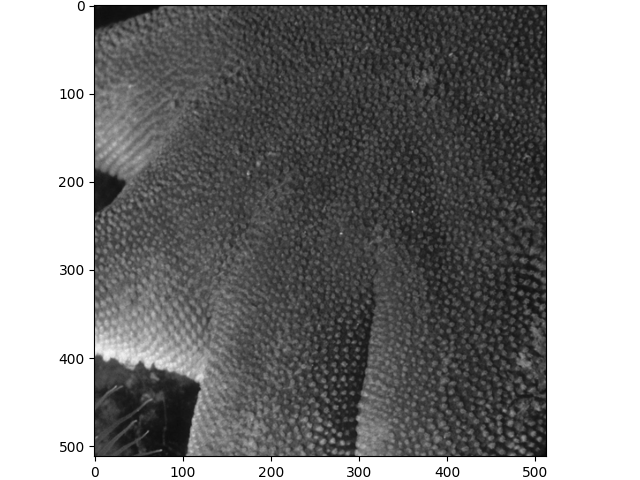

In [30]:
tt.show(train_dataset[0])

In [32]:
import torchOptics.metrics as tm
valid = train_dataset[0].unsqueeze(0)
sign_function = SignFunction.apply
z = 0
with torch.no_grad():
    out = model(valid)
    binary = sign_function(out)
    sim = tt.simulate(binary, z).abs()**2
    result = torch.mean(sim, dim=1, keepdim=True)
    psnr = tt.relativeLoss(result, valid, tm.get_PSNR)
    # psnrList.append(psnr)
    mse = tt.relativeLoss(result, valid, F.mse_loss)
    # mseList.append(mse)


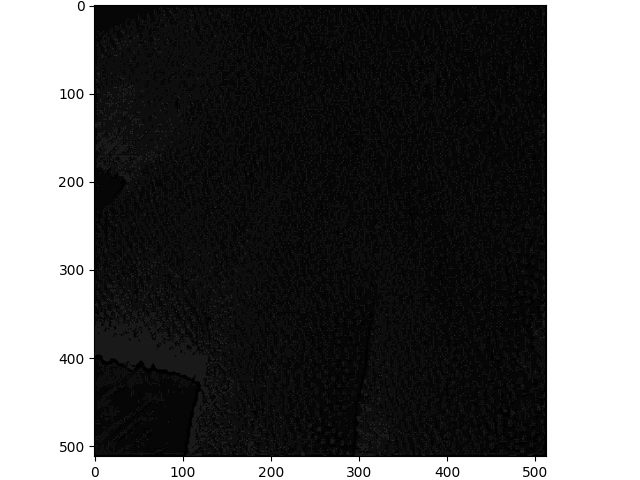

In [33]:
tt.show(result)

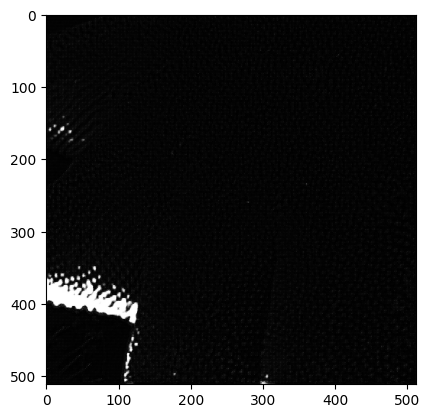

{'wl': 6.38e-07, 'dx': (6.3e-06, 6.3e-06)}

In [41]:
out[0][5]

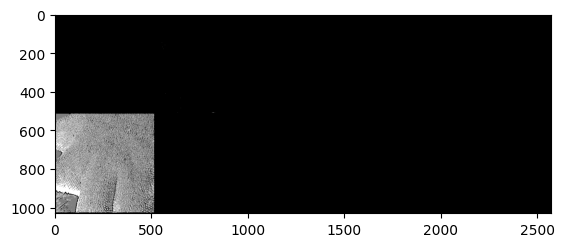

{'wl': 6.38e-07, 'dx': (6.3e-06, 6.3e-06)}

In [38]:
binary


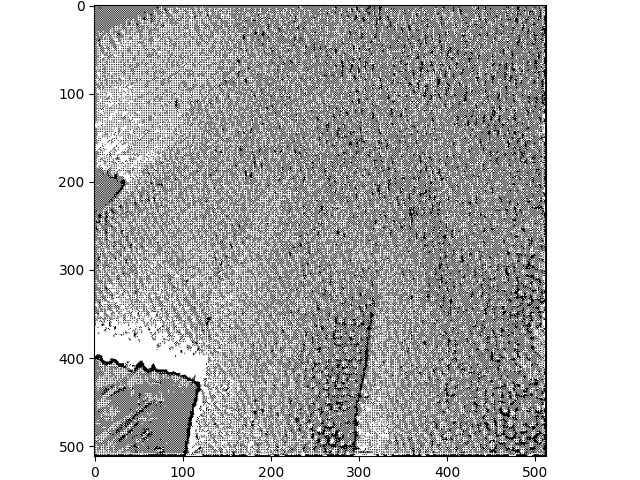

In [36]:
tt.show(binary[0][5])

In [37]:
print(psnr, mse)

13.49085807800293 0.04268079996109009


In [10]:
model = torch.load('models/densenet3_binary_240324_test.pt')

In [11]:
out = model(valid_dataset[0].unsqueeze(0))


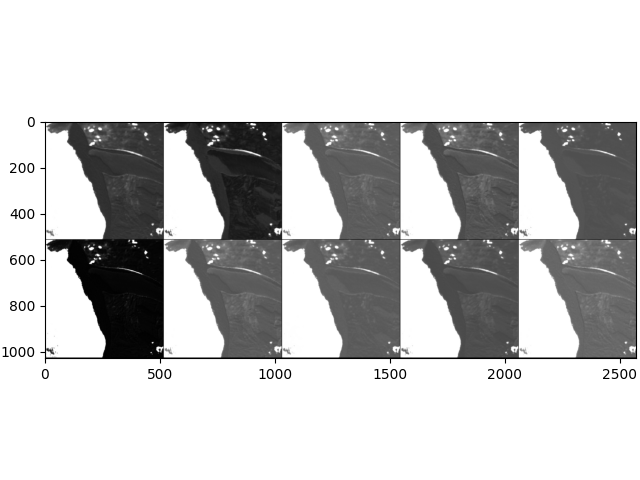

In [9]:
tt.show(out)


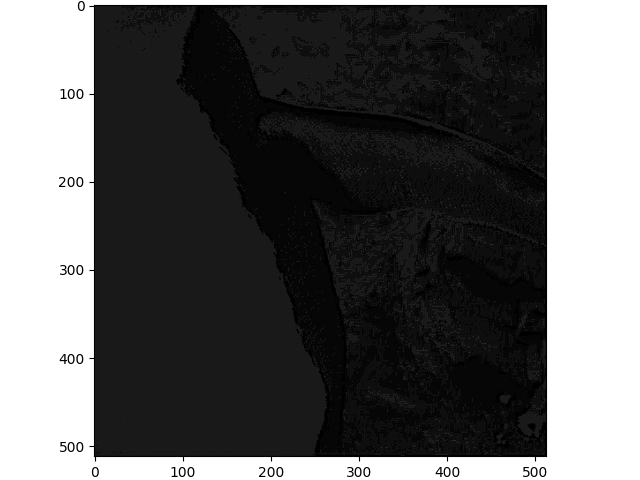

In [12]:
binary = SignFunction.apply(out)
sim = tt.simulate(binary, 0).abs()**2
sum = torch.mean(sim, dim=1, keepdim=True)
tt.show(sum)


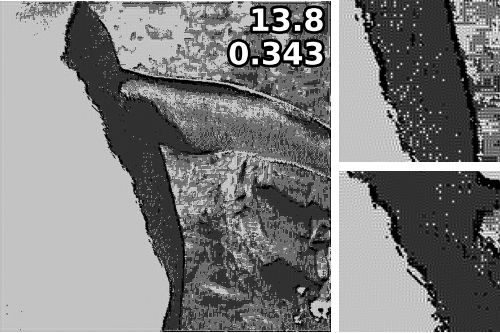

In [13]:
tt.show_with_insets(sum, valid_dataset[0].unsqueeze(0))


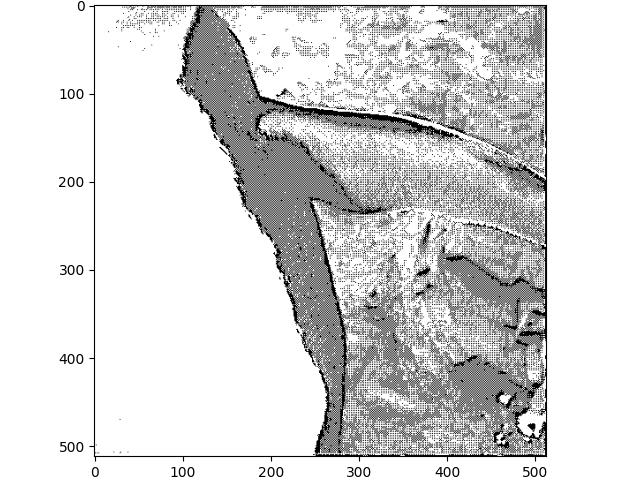

In [14]:
tt.show(binary[0][5])


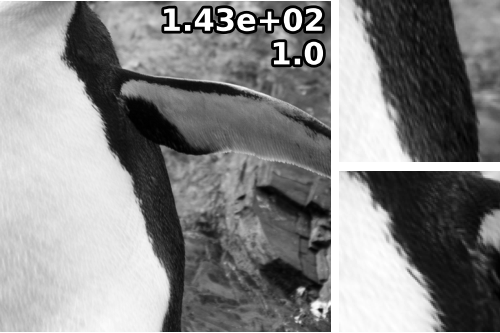

In [16]:
tt.show_with_insets(valid_dataset[0].unsqueeze(0), valid_dataset[0].unsqueeze(0))